In [478]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import tqdm
import controlpy
from control_utils import compute_traj_cost

In [479]:
A = np.array([[1,1],[0,1]])
B = np.array([[0],[1]])

n = A.shape[0]
m = B.shape[1]

Q = np.eye(2)
R = np.eye(1)
S = np.zeros((2,1))

In [480]:
s_rand = 0.05
s_model = 0.1
randcov = np.random.randn(n + m, n + m) * s_rand
randcov = randcov.T @ randcov
model_cov = np.eye(n + m) * s_model + randcov
sigma_w = np.eye(n) * 0.1

def get_perturbed_model(A, B):    
    sample = np.random.multivariate_normal(np.zeros(n+m), sigma_w[0,0] * model_cov, n)
    A_hat = A + sample[:,:n]
    B_hat = B + sample[:,n:].reshape((n,m))
    return A_hat, B_hat

def is_controllable(A, B):
    return np.linalg.matrix_rank(np.hstack((B, A @ B))) == 2
A_hat, B_hat = get_perturbed_model(A,B)
print(is_controllable(A_hat, B_hat))
print(model_cov)
print(np.trace(model_cov))

True
[[ 0.1052  -0.00206 -0.00115]
 [-0.00206  0.10288 -0.00379]
 [-0.00115 -0.00379  0.11455]]
0.3226350464264197


In [481]:
def iterate_are(P_next, A_hat, B_hat, Q, R, S, model_cov, sigma_w, lr=1):
    Q_hat = model_cov[:n,:n]
    R_hat = model_cov[n:,n:]
    S_hat = model_cov[:n, n:]
    gamma = np.trace(P_next @ sigma_w)
    F = - np.linalg.inv(R + gamma * R_hat + B_hat.T @ P_next @ B_hat) @  (S.T  + gamma * S_hat.T +  B_hat.T @ P_next @ A_hat)
    P_curr = Q + gamma * Q_hat - (S + gamma * S_hat + A_hat.T @ P_next @ B_hat) @ np.linalg.inv(R + gamma * R_hat + B_hat.T @ P_next @ B_hat) @ (S.T + gamma * S_hat.T + B_hat.T @ P_next @ A_hat) + A_hat.T @ P_next @ A_hat
    P_curr = lr * P_curr + (1 - lr) * P_next
    return P_curr, F

def solve_mod_are(A_hat, B_hat, Q, R, S, model_cov, sigma_w, tol=1e-10, max_iter=500):
    P = scipy.linalg.solve_discrete_are(A_hat, B_hat, Q, R,s=S)
    converged = False
    P_curr = P
    for i in range(max_iter):
        P_curr, F = iterate_are(P, A_hat, B_hat, Q, R, S, model_cov, sigma_w)
        if np.linalg.norm(P - P_curr) <= tol:
            converged = True
            break
        P = P_curr
    return P, F, converged
    

In [482]:
P_ce = scipy.linalg.solve_discrete_are(A_hat, B_hat, Q, R,s=S)
Ps = [P_ce]
Fs = []
N = 500
for i in range(N):
    P_curr, F_curr = iterate_are(Ps[-1], A_hat, B_hat, Q, R, S, model_cov, sigma_w)
    Ps.append(P_curr)
    Fs.append(F_curr)
P_stoch = Ps[-1]
F_ce = Fs[-1]
PP, F, conv = solve_mod_are(A_hat, B_hat, Q, R, S, model_cov, sigma_w)
print(np.linalg.norm(PP - P_stoch))
K, P_ce, _ = controlpy.synthesis.controller_lqr_discrete_time(A_hat, B_hat, Q, R)
print(np.linalg.norm(P_ce - PP), np.linalg.norm(K + F))

9.259444961443233e-11
0.33564089120568125 0.0016045509341891453


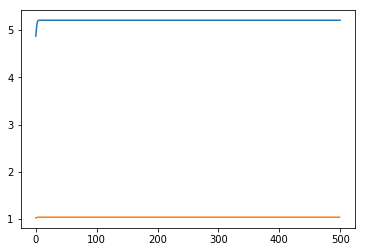

In [483]:
P_norms = [np.linalg.norm(P) for P in Ps]
F_norms = [np.linalg.norm(F) for F in Fs]
plt.plot(P_norms)
plt.plot(F_norms)

In [484]:
def sim_traj(x0, A, B, F, sigma_w, episode_length):
    x_traj = [x0]
    u_traj = []
    for _ in range(episode_length):
        x = x_traj[-1]
        u = F @ x_traj[-1]
        z = np.hstack((x,u))
        x_next = A @ x + B @ u + np.random.multivariate_normal(np.zeros(A.shape[0]), sigma_w)
        x_traj.append(x_next)
        u_traj.append(u)
    return np.array(x_traj), np.array(u_traj)

def sim_experiment(x0, A, B, sigma_w, episode_length):
    A_hat, B_hat = get_perturbed_model(A, B)
    K, P_ce, _ = controlpy.synthesis.controller_lqr_discrete_time(A_hat, B_hat, Q, R)
    F_ce = -K
    P_stoch, F_stoch, converged = solve_mod_are(A_hat, B_hat, Q, R, S, model_cov, sigma_w)
    if converged:
        x_ce, u_ce = sim_traj(x0, A, B, F_ce, sigma_w, episode_length)
        x_stoch, u_stoch = sim_traj(x0, A, B, F_stoch, sigma_w, episode_length)
        return True, (x_ce, u_ce, P_ce, F_ce), (x_stoch, u_stoch, P_stoch, F_stoch)
    else:
        return False, None, None

In [490]:
num_experiments = 100
# num_episodes = 10
episode_length = 50
ce_results = []
stoch_results = []
x0 = np.array([4,0])
for _ in tqdm.tqdm(range(num_experiments)):
    converged, ce_res, stoch_res = sim_experiment(x0, A, B, sigma_w, episode_length)
    if converged:
        ce_results.append(ce_res)
        stoch_results.append(stoch_res)
print(len(stoch_results))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.40it/s]


100


In [506]:
h = lambda x,u: x.T @ Q @ x + u.T @ R @ u

def comp_c2gs(result):
    
    c2gs = [compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h) for x_traj, u_traj, P, F in result]
    return np.vstack(c2gs)

def comp_est_c2gs(sigma_w, result):
    c2gs = [[x.T @ P @ x + np.trace(P @ sigma_w) for x in np.rollaxis(x_traj,0)] for x_traj, u_traj, P, F in result]
    return np.vstack(c2gs)
    
def is_unstable(res):
    x_traj = res[0]
    return np.linalg.norm(x_traj[-1,:]) >= 5e10

def split_stable(result):
    stable = [res for res in result if not is_unstable(res)]
    unstable = [res for res in result if is_unstable(res)]
    return stable, unstable

In [507]:
stable_stoch, unstable_stoch = split_stable(stoch_results)
stable_ce, unstable_ce = split_stable(ce_results)
c2gs_stoch = comp_c2gs(stable_stoch)
c2gs_ce = comp_c2gs(stable_ce)
c2gs_stoch_est = comp_est_c2gs(sigma_w, stable_stoch)
c2gs_ce_est = comp_est_c2gs(sigma_w, stable_ce)

In [508]:
def plot_with_cov(x, color="b", alpha=0.3):
    means = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    hi = means + 2 * std
    lo = np.maximum(means - 2 * std,0)
    plt.plot(means, color)
    plt.fill_between(np.arange(x.shape[1]), hi, lo, color=color, alpha=alpha)

100.0 100.0


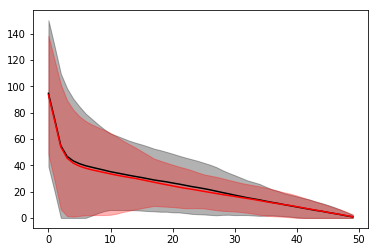

In [509]:
plt.figure()
plot_with_cov(c2gs_ce, color="k")
plot_with_cov(c2gs_stoch, color="r")
stoch_pct = len(stable_stoch) / (len(stable_stoch) + len(unstable_stoch)) * 100
ce_pct = len(stable_ce) / (len(stable_ce) + len(unstable_ce)) * 100
print(stoch_pct, ce_pct)

[40.40174 42.15679 42.4681  48.03046 52.17728 53.70127 64.3199  46.35277
 54.00762 54.43464 48.93941 45.10723 49.93238 46.66128 54.06822 58.45988
 58.38528 49.88788 98.89775 50.69552 36.06619 32.14199 42.785   57.14307
 45.76239 60.50823 58.78412 61.3475  53.21772 43.35015 47.255   35.58765
 40.16247 35.48338 53.00183 37.99916 65.31099 57.0282  28.37479 44.87194
 53.72629]


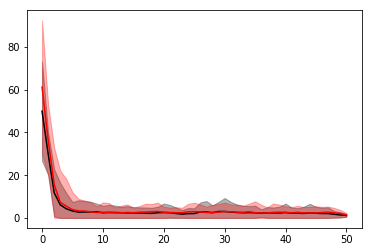

In [505]:
plt.figure()
plot_with_cov(c2gs_ce_est, color="k")
plot_with_cov(c2gs_stoch_est, color="r")
print(c2gs_ce_est[:,0])

(-5, 5)

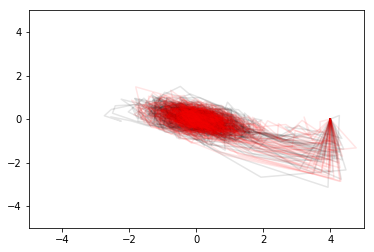

In [477]:
plt.figure()
for x_traj, _, _, _ in stable_ce:
    plt.plot(x_traj[:,0], x_traj[:,1], "k", alpha=0.1)
for x_traj, _, _, _ in stable_stoch:
    plt.plot(x_traj[:,0], x_traj[:,1], "r", alpha=0.1)

plt.xlim((-5,5))
plt.ylim((-5,5))

In [311]:
len(stoch_results)

977

In [312]:
x = np.ones(3)
x.T @ model_cov @ x

0.34561044555984066

In [313]:
A = np.random.rand(2,2)
np.linalg.eig(-A)

(array([-0.44188, -0.21495]), array([[-0.3665 ,  0.03979],
        [-0.93042, -0.99921]]))

In [314]:
np.linalg.eig(A@A)

(array([0.19526, 0.0462 ]), array([[ 0.3665 , -0.03979],
        [ 0.93042,  0.99921]]))

In [320]:
a = []
b = [1,2,3]

In [321]:
a + b

[1, 2, 3]

In [414]:
i = 9
stoch_c2gs = np.vstack([compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h) for x_traj, u_traj in zip(*stoch_results[i][:2])])
ce_c2gs = np.vstack([compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h) for x_traj, u_traj in zip(*ce_results[i][:2])])